In [35]:
import csv

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.preprocessing import label_binarize

tf.device('/gpu:0')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
RANDOM_SEED = 42

Num GPUs Available:  0


# Specify each path

In [36]:
dataset = '../model/keypoint_classifier/keypoint.csv'
model_save_path = '../model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = '../model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [37]:
NUM_CLASSES = 6

# Dataset reading

In [47]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [39]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Xử lý dữ liệu

## THỐNG KÊ VÀ TÌM HIỂU DỮ LIỆU

---

In [48]:
X_dataset_check = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(0, (21 * 2) + 1)))
X_dataset_check = pd.DataFrame(X_dataset_check)
print(X_dataset_check)

        0    1    2         3         4         5         6         7   \
0      0.0  0.0  0.0 -0.142105  0.026316 -0.294737 -0.005263 -0.315789   
1      0.0  0.0  0.0 -0.142857  0.021978 -0.302198 -0.027473 -0.313187   
2      0.0  0.0  0.0 -0.150838  0.016760 -0.307263 -0.039106 -0.318436   
3      0.0  0.0  0.0 -0.149425  0.022989 -0.316092 -0.022989 -0.321839   
4      0.0  0.0  0.0 -0.161677  0.005988 -0.329341 -0.053892 -0.323353   
...    ...  ...  ...       ...       ...       ...       ...       ...   
25558  2.0  0.0  0.0 -0.158730 -0.253968 -0.169312 -0.587302 -0.042328   
25559  2.0  0.0  0.0 -0.167539 -0.251309 -0.178010 -0.586387 -0.047120   
25560  2.0  0.0  0.0 -0.173684 -0.252632 -0.184211 -0.584211 -0.057895   
25561  2.0  0.0  0.0 -0.166667 -0.244792 -0.182292 -0.583333 -0.041667   
25562  2.0  0.0  0.0 -0.162679 -0.205742 -0.210526 -0.521531 -0.110048   

             8         9   ...        33        34        35        36  \
0     -0.142105 -0.289474  ... -0.168

In [54]:
# Lọc các hàng có giá trị khác 1 và 3 ở cột 1
X_dataset_check = X_dataset_check.loc[(X_dataset_check[0] != 1) & (X_dataset_check[0] != 2)]
# filtered_df.to_csv('filtered_data.csv', index=False)
X_dataset_check[0].value_counts()
X_dataset_check.to_csv('filtered_data.csv', index=False)

0
0.0    5360
5.0    5100
4.0    3497
3.0    3439
Name: count, dtype: int64

In [43]:
X_dataset_check.head(15)

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42


In [44]:
# In thông tin các cột trong DF => không tồn tại kiểu dự liệu phi số, không sữ liệu rỗng, dữ liệu đã được tiền xử lý
X_dataset_check.info()
print('Shape tập dữ liệu: ', X_dataset_check.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 43 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       0 non-null      float32
 1   1       0 non-null      float32
 2   2       0 non-null      float32
 3   3       0 non-null      float32
 4   4       0 non-null      float32
 5   5       0 non-null      float32
 6   6       0 non-null      float32
 7   7       0 non-null      float32
 8   8       0 non-null      float32
 9   9       0 non-null      float32
 10  10      0 non-null      float32
 11  11      0 non-null      float32
 12  12      0 non-null      float32
 13  13      0 non-null      float32
 14  14      0 non-null      float32
 15  15      0 non-null      float32
 16  16      0 non-null      float32
 17  17      0 non-null      float32
 18  18      0 non-null      float32
 19  19      0 non-null      float32
 20  20      0 non-null      float32
 21  21      0 non-null      float32
 22  22      0 non-null 

## Check số lượng các nhãn
---

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

def categories_counts(label_name, dataset):
    print(f'-----------------------------------------------')
    print(f'Số các giá trị duy nhất của cột {label_name}:')
    print(dataset[label_name].value_counts())
    
def plt_categories_counts(label_name, dataset):
    counts = dataset[label_name].value_counts()
    plt.figure(figsize=(10, 6))
    counts.plot(kind='bar')
     # Hiển thị số liệu trên các cột
    for i, count in enumerate(counts):
        plt.annotate(str(count), xy=(i, count), ha='center', va='bottom')
    plt.title(f'Số lượng giá trị duy nhất của cột {label_name}')
    plt.xlabel(label_name)
    plt.ylabel('Counts')
    plt.show()
    categories_counts(label_name, dataset)

label = X_dataset_check[0]
label = pd.DataFrame(label)

a = len(label)
new_column = [None] * len(label)
new_column = pd.DataFrame(new_column)
label = pd.concat([new_column,label],axis=1)
label.columns = ['Nhãn', 'Quy đổi']

label.loc[label['Quy đổi'] == 0, 'Nhãn'] = 'Nothing'
label.loc[label['Quy đổi'] == 1, 'Nhãn'] = 'Left'
label.loc[label['Quy đổi'] == 2, 'Nhãn'] = 'Right'
label.loc[label['Quy đổi'] == 3, 'Nhãn'] = 'Rotate'
label.loc[label['Quy đổi'] == 4, 'Nhãn'] = 'Down'
label.loc[label['Quy đổi'] == 5, 'Nhãn'] = 'Click'

print(label)

# Đếm các giá trị duy nhất của các cột có Nhãn 
plt_categories_counts('Nhãn', label)


ValueError: Length mismatch: Expected axis has 1 elements, new values have 2 elements

## Kiểm tra mức độ sạch của dữ liệu
---

In [ ]:
def statistical_missing_data(dataFrame):
    # Kiểm tra số lượng giá trị khuyết cho mỗi cột
    missing_data = dataFrame.isnull().sum()
    
    # Tính tổng số lượng giá trị khuyết
    duplicate_data = dataFrame.duplicated().sum()

    # Tính tỷ lệ giá trị khuyết trên tổng số giá trị
    percent_missing = (duplicate_data / (dataFrame.shape[0] * dataFrame.shape[1])) * 100

    print("Số liệu thiếu trong mỗi cột:, ")
    print(missing_data)
    print("\nSố liệu trùng lặp: ", duplicate_data)
    print("Tỷ lệ giá trị khuyết trên tổng số giá trị (%): {:.2f}".format(percent_missing))

# Thống kê dữ liệu khuyết
statistical_missing_data(X_dataset_check)

Số liệu thiếu trong mỗi cột:, 
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
dtype: int64

Số liệu trùng lặp:  1
Tỷ lệ giá trị khuyết trên tổng số giá trị (%): 0.00


In [ ]:
def plt_statistics_missing_data(dataFrame):
    # Dữ liệu khuyết
    missing_data = dataFrame.isnull().sum()
    missing_data = missing_data[missing_data > 0]
    plt.figure(figsize=(10, 5))
    missing_data.plot(kind='bar')
    plt.title('Dữ liệu khuyết trong mỗi cột')
    plt.xlabel('Tên cột')
    plt.ylabel('Số lượng dữ liệu khuyết')
    plt.show()

    # Dữ liệu lặp
    duplicate_data = dataFrame.duplicated().sum()
    print("\nSố liệu trùng lặp:", duplicate_data)

# Thống kê dữ liệu khuyết
# plt_statistics_missing_data(X_dataset_check)
missing_data = X_dataset_check.isnull().sum()
print(missing_data.to_frame().T)
# missing_data.to_frame().T.to_csv('../test.txt', sep='\t', index=False)


   0   1   2   3   4   5   6   7   8   9   ...  33  34  35  36  37  38  39  \
0   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

   40  41  42  
0   0   0   0  

[1 rows x 43 columns]


In [ ]:
X_dataset_check.describe()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
X_dataset_check

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42


In [ ]:
# find the correlation among the columns in the Dataframe
X_dataset_check.corr()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


c:\Users\ADMIN\anaconda3\envs\env1\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\ADMIN\anaconda3\envs\env1\lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


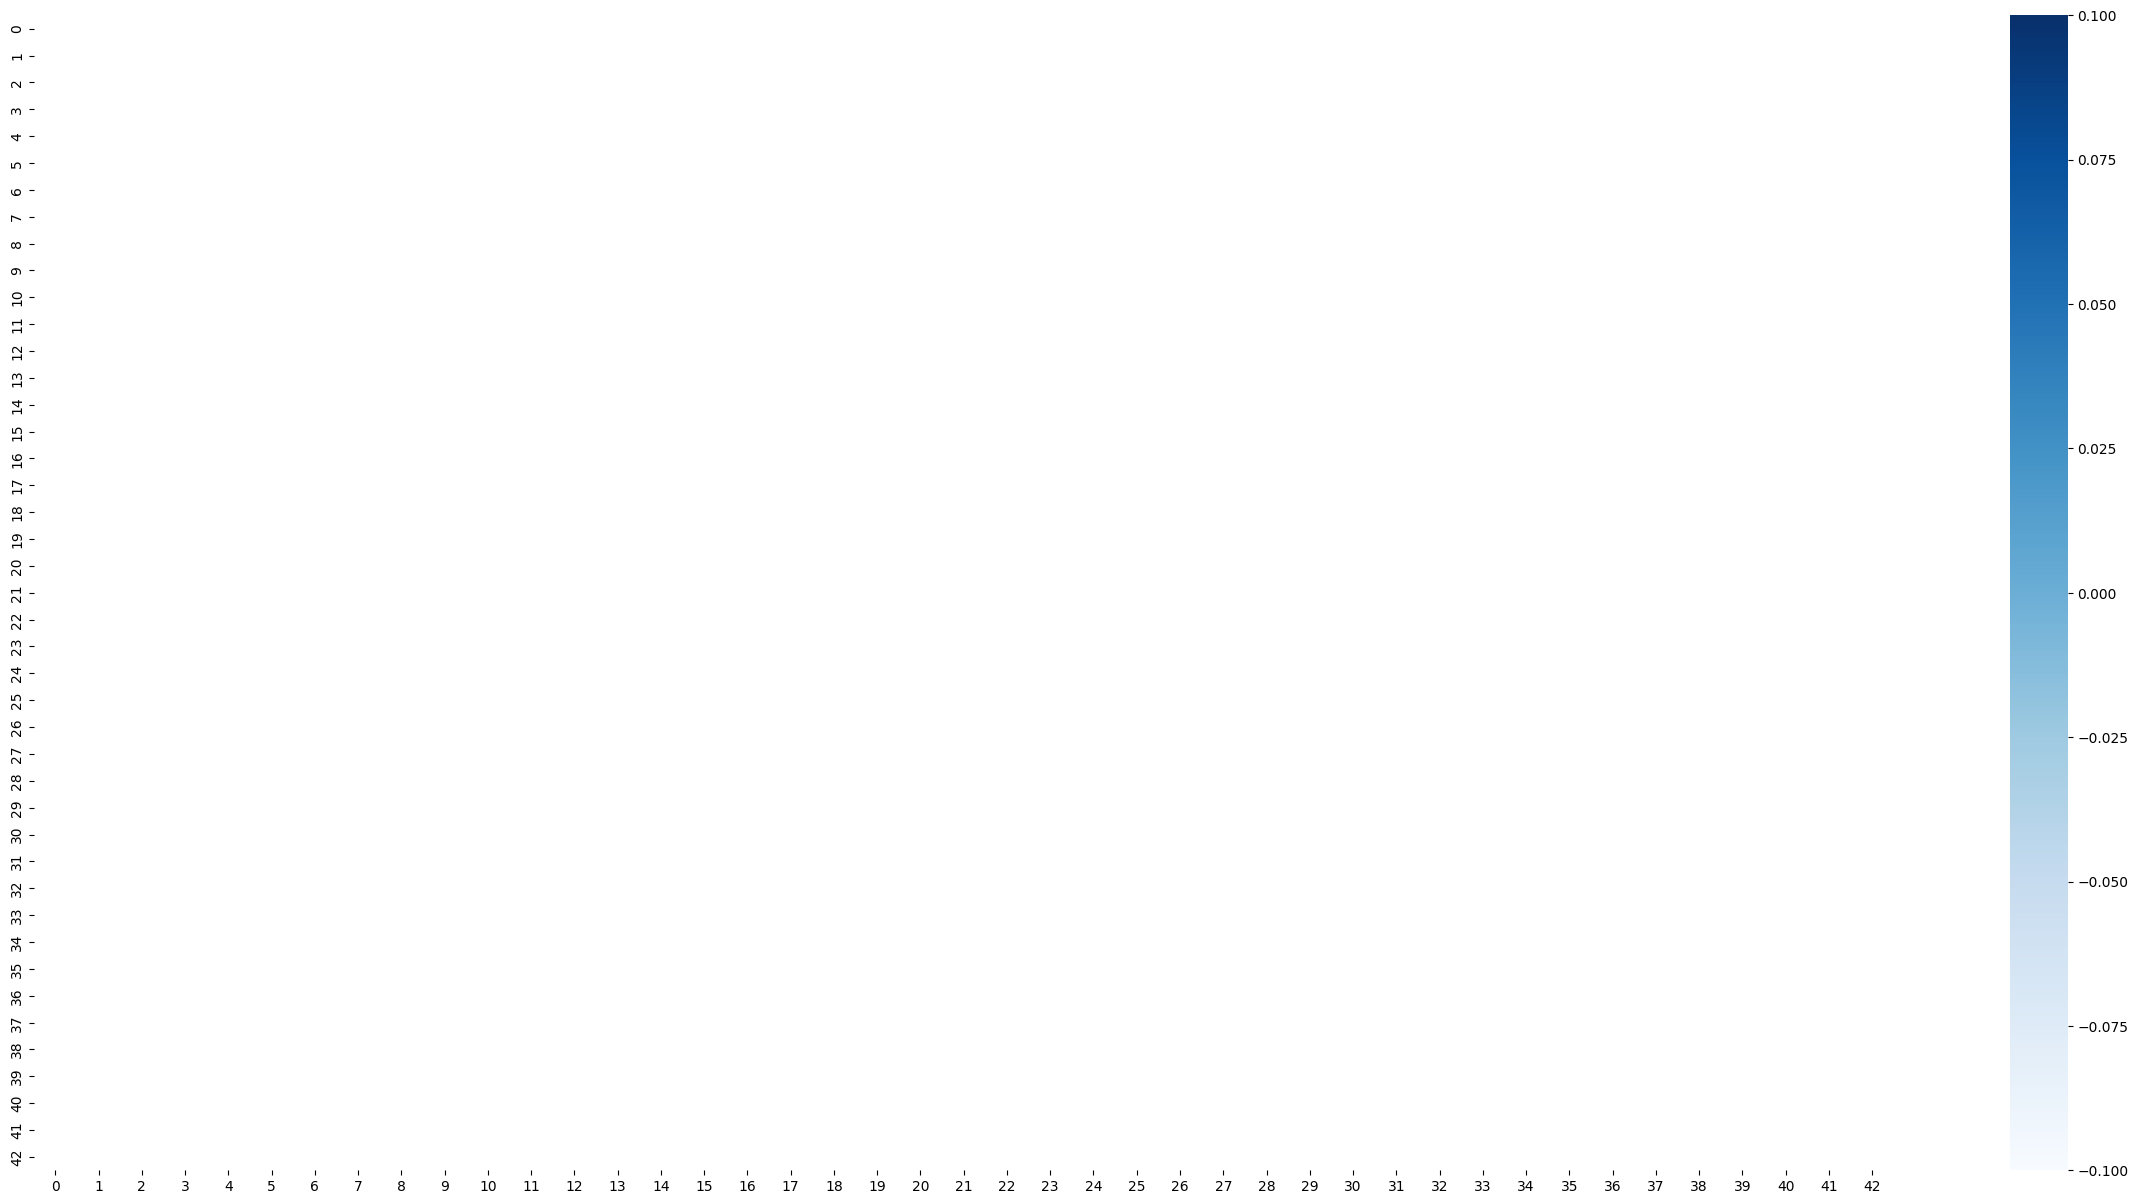

In [ ]:
plt.figure(figsize = (30,15))
sns.heatmap(X_dataset_check.corr(numeric_only = True), annot = True, cmap = plt.cm.Blues)
plt.show()

# Model building

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),   
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [ ]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 6)                 66        
                                                                 
Total params: 1,136
Trainable params: 1,136
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False) # automatically save your model
# verbose : gọi lại thông báo mỗi khi thông báo
# save_weights_only: lưu lại cả mô hình lẫn thông số mô hình nếu False

# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)
# dừng quá trình đào tạo nếu hiệu suất mô hình ko đc cải thiện

In [ ]:
# Model compilation
model.compile(
    optimizer='adam', # hàm tối ưu
    loss='sparse_categorical_crossentropy', # hàm mất mát
    metrics=['accuracy'] # thuước  đo đánh giá
)

# Model training

In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
145/150 [============================>.] - ETA: 0s - loss: 1.8678 - accuracy: 0.1988
Epoch 1: saving model to ../model/keypoint_classifier\keypoint_classifier.hdf5
150/150 [==============================] - 1s 5ms/step - loss: 1.8635 - accuracy: 0.2007 - val_loss: 1.6668 - val_accuracy: 0.4004
Epoch 2/1000
140/150 [===========================>..] - ETA: 0s - loss: 1.6603 - accuracy: 0.3089
Epoch 2: saving model to ../model/keypoint_classifier\keypoint_classifier.hdf5
150/150 [==============================] - 1s 3ms/step - loss: 1.6557 - accuracy: 0.3111 - val_loss: 1.4393 - val_accuracy: 0.5605
Epoch 3/1000
143/150 [===========================>..] - ETA: 0s - loss: 1.5142 - accuracy: 0.3725
Epoch 3: saving model to ../model/keypoint_classifier\keypoint_classifier.hdf5
150/150 [==============================] - 1s 5ms/step - loss: 1.5118 - accuracy: 0.3737 - val_loss: 1.2195 - val_accuracy: 0.6813
Epoch 4/1000
142/150 [===========================>..] - ETA: 0s - loss: 1.42

In [ ]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

50/50 [==============================] - 0s 4ms/step - loss: 0.6968 - accuracy: 0.7888


In [ ]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [ ]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 137ms/step
[0.07713841 0.01596003 0.00211285 0.02382168 0.00183496 0.8791321 ]
5


# Draw Loss and Accuracy

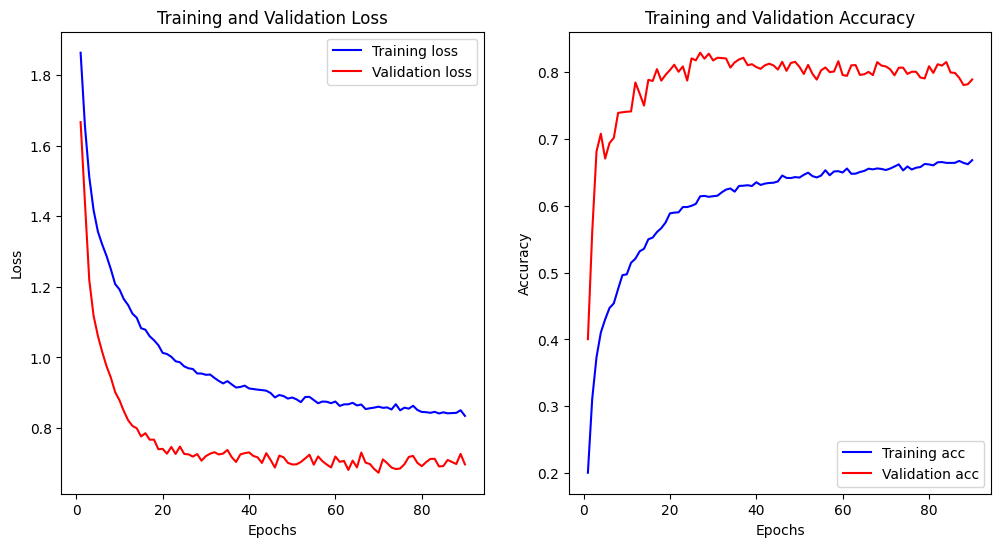

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Lấy thông tin về loss và accuracy từ history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)

    # Vẽ biểu đồ Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Vẽ biểu đồ Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_training_history(history)

200/200 [==============================] - 0s 1ms/step
Accuracy: 0.7887654514160538
Precision: 0.7854207739259754
Recall: 0.789948486768537
ROC AUC: 0.9611754284480344
F1-score for class 0 : 0.7865655471289275
F1-score for class 1 : 0.681135225375626
F1-score for class 2 : 0.7267355982274741
F1-score for class 3 : 0.8421610169491525
F1-score for class 4 : 0.8196908986834573
F1-score for class 5 : 0.855686274509804
Average F1-score: 0.7864733906509754
ROC AUC: {0: 0.96848237592929, 1: 0.9432279424394415, 2: 0.9312500979946378, 3: 0.9823302187300019, 4: 0.9765427735214318, 5: 0.965219162073404}


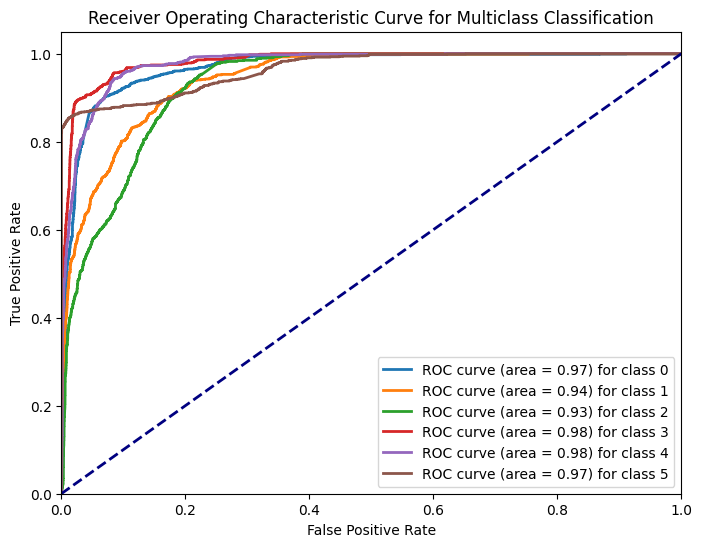

In [ ]:
# Định nghĩa hàm plot_roc_curve để vẽ đường cong ROC
def plot_roc_curve(fpr, tpr):
    # Vẽ đường cong ROC cho từng lớp
    plt.figure(figsize=(8, 6))
    for i in range(NUM_CLASSES):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve for Multiclass Classification')
    plt.legend(loc="lower right")
    plt.show()

# Dự đoán xác suất cho từng lớp
y_pred_prob = model.predict(X_test)
# Chọn ra lớp có xác suất cao nhất
y_pred = np.argmax(y_pred_prob, axis=1)

# Tính toán các metric
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

# In kết quả
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("ROC AUC:", roc_auc)

# Tính toán F1-score cho mỗi lớp
f1_scores = f1_score(y_test, y_pred, average=None)

# In ra F1-score của từng lớp
for i in range(NUM_CLASSES):
    print("F1-score for class", i, ":", f1_scores[i])

# Tính toán F1-score trung bình trên tất cả các lớp
average_f1_score = f1_score(y_test, y_pred, average='weighted')
print("Average F1-score:", average_f1_score)

def draw_roc_corve():
    
    # Chuyển đổi nhãn về dạng one-hot encoding
    y_test_one_hot = label_binarize(y_test, classes=np.arange(NUM_CLASSES))

    # Tính toán đường cong ROC cho mỗi lớp
    fpr = dict()
    tpr = dict()
    global roc_auc
    roc_auc = dict()
    for i in range(NUM_CLASSES):
        fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    print("ROC AUC:", roc_auc)
    # Vẽ đường cong ROC
    plot_roc_curve(fpr, tpr)
draw_roc_corve()

# Confusion matrix

200/200 [==============================] - 0s 958us/step


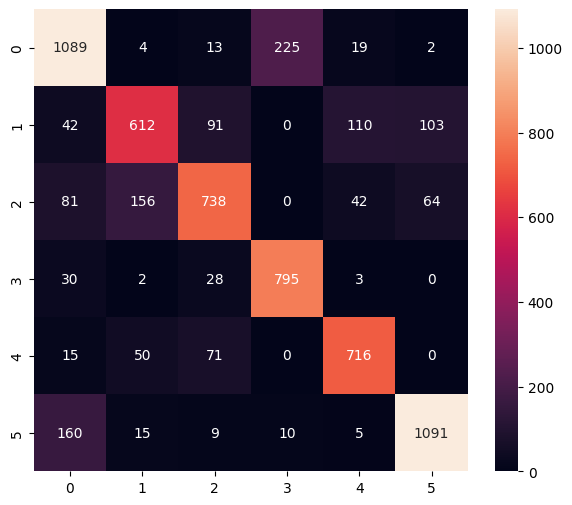

Classification Report
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      1352
           1       0.73      0.64      0.68       958
           2       0.78      0.68      0.73      1081
           3       0.77      0.93      0.84       858
           4       0.80      0.84      0.82       852
           5       0.87      0.85      0.86      1290

    accuracy                           0.79      6391
   macro avg       0.79      0.79      0.79      6391
weighted avg       0.79      0.79      0.79      6391



In [ ]:
# phải sửa lại dữ liệu left và right, sửa thành tay kéo và like
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [ ]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [ ]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ADMIN\AppData\Local\Temp\tmpihs7ydng\assets


6632

# Inference test

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [ ]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 42]), 'shape_signature': array([-1, 42]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [ ]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.07713841 0.01596002 0.00211285 0.02382166 0.00183496 0.87913215]
5
